# Bigmart Sales Prediction 2

## Load required libraries and data

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingClassifier, AdaBoostRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read files:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data Exploration
### Combine the train and test data for feature engineering.

In [4]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test],ignore_index=True)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [5]:
data.head()

Item_Fat_Content Item_Identifier  Item_MRP  Item_Outlet_Sales  \
0          Low Fat           FDA15  249.8092          3735.1380   
1          Regular           DRC01   48.2692           443.4228   
2          Low Fat           FDN15  141.6180          2097.2700   
3          Regular           FDX07  182.0950           732.3800   
4          Low Fat           NCD19   53.8614           994.7052   

               Item_Type  Item_Visibility  Item_Weight  \
0                  Dairy         0.016047         9.30   
1            Soft Drinks         0.019278         5.92   
2                   Meat         0.016760        17.50   
3  Fruits and Vegetables         0.000000        19.20   
4              Household         0.000000         8.93   

   Outlet_Establishment_Year Outlet_Identifier Outlet_Location_Type  \
0                       1999            OUT049               Tier 1   
1                       2009            OUT018               Tier 3   
2                       1999            OUT049               Tier 1   
3                       1998            OUT010               Tier 3   
4                       1987            OUT013               Tier 3   

  Outlet_Size        Outlet_Type source  
0      Medium  Supermarket Type1  train  
1      Medium  Supermarket Type2  train  
2      Medium  Supermarket Type1  train  
3         NaN      Grocery Store  train  
4        High  Supermarket Type1  train

### How many values are missing feature wise?

In [6]:
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

### Statistical overview of data

In [7]:
data.describe()

Item_MRP  Item_Outlet_Sales  Item_Visibility   Item_Weight  \
count  14204.000000        8523.000000     14204.000000  11765.000000   
mean     141.004977        2181.288914         0.065953     12.792854   
std       62.086938        1706.499616         0.051459      4.652502   
min       31.290000          33.290000         0.000000      4.555000   
25%       94.012000         834.247400         0.027036      8.710000   
50%      142.247000        1794.331000         0.054021     12.600000   
75%      185.855600        3101.296400         0.094037     16.750000   
max      266.888400       13086.964800         0.328391     21.350000   

       Outlet_Establishment_Year  
count               14204.000000  
mean                 1997.830681  
std                     8.371664  
min                  1985.000000  
25%                  1987.000000  
50%                  1999.000000  
75%                  2004.000000  
max                  2009.000000

In [8]:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [9]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']

#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]

#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

## Data Cleaning

### Imputing Missing Values

In [10]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight[x])
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [11]:
print(data['Outlet_Size'].unique())
outlet_size_mapping = {'Small': 1, 'Medium': 2, 'High': 3}
data['Outlet_Size'] = data['Outlet_Size'].map(outlet_size_mapping)
outlet_size_inverse_mapping = {1: 'Small', 2: 'Medium', 3: 'High'}

['Medium' nan 'High' 'Small']


In [12]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x:mode(x).mode[0]) )

print('Mode for each Outlet_Type:')
print(outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print(sum(data['Outlet_Size'].isnull()))

data['Outlet_Size'] = data['Outlet_Size'].map(outlet_size_inverse_mapping)
print(data['Outlet_Size'].head())

Mode for each Outlet_Type:
Outlet_Type
Grocery Store        1.0
Supermarket Type1    1.0
Supermarket Type2    2.0
Supermarket Type3    2.0
Name: Outlet_Size, dtype: float64

Orignal #missing: 4016
0
0    Medium
1    Medium
2    Medium
3     Small
4      High
Name: Outlet_Size, dtype: object


## Feature Engineering

In [13]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg[x])
print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [14]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [15]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [16]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [17]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [18]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [19]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [20]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [21]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0           float64
Item_Fat_Content_1           float64
Item_Fat_Content_2           float64
Outlet_Location_Type_0       float64
Outlet_Location_Type_1       float64
Outlet_Location_Type_2       float64
Outlet_Size_0                float64
Outlet_Size_1                float64
Outlet_Size_2                float64
Outlet_Type_0                float64
Outlet_Type_1                float64
Outlet_Type_2                float64
Outlet_Type_3                float64
Item_Type_Combined_0         float64
Item_Type_Combined_1         float64
Item_Type_Combined_2         float64
O

In [22]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Model building

In [23]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
features = [x for x in train.columns if x not in [target]+IDcol]
print(features)
X = train[features]
y = train[target]

['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Item_Visibility_MeanRatio', 'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2', 'Outlet_Location_Type_0', 'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0', 'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0', 'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9']


### Divide the train data into train and test(validation) data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Baseline Model

In [25]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("alg0.csv",index=False)

/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
train.columns

Index(['Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales', 'Item_Visibility',
       'Item_Weight', 'Outlet_Identifier', 'Item_Visibility_MeanRatio',
       'Outlet_Years', 'Item_Fat_Content_0', 'Item_Fat_Content_1',
       'Item_Fat_Content_2', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_Type_Combined_0',
       'Item_Type_Combined_1', 'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1',
       'Outlet_2', 'Outlet_3', 'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7',
       'Outlet_8', 'Outlet_9'],
      dtype='object')

## Linear Regression Model

### Diagnosing bias and variance problems with learning curves

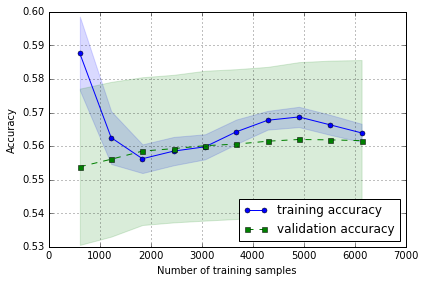

In [27]:
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LinearRegression())])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                train_sizes=np.linspace(0.1, 1.0, 10), 
                cv=10,
                n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

### Prepare the linear regression model on the divided training data

In [28]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

### See the performance of the model on the training data

In [29]:
#prediction on training data
model_lr_train_prediction = model_lr.predict(train[features])

#Perform cross-validation:
cv_score = cross_val_score(model_lr, train[features], train[target], cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(train[target].values, model_lr_train_prediction)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),
                                                                         np.std(cv_score),np.min(cv_score),
                                                                         np.max(cv_score)))


Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 43.06 | Min - 1075 | Max - 1209


### See the performance of the model on the test(validation) data

In [30]:
#prediction on training data
model_lr_test_prediction = model_lr.predict(X_test)

#Perform cross-validation:
cv_score = cross_val_score(model_lr, X_test, y_test, cv=20, scoring='mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

#Print model report:
print("\nModel Report")
print("RMSE : %.4g" % np.sqrt(mean_squared_error(y_test.values, model_lr_test_prediction)))
print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),
                                                                         np.std(cv_score),np.min(cv_score),
                                                                         np.max(cv_score)))


Model Report
RMSE : 1142
CV Score : Mean - 1138 | Std - 129.2 | Min - 812.8 | Max - 1362


### Prepare the linear regression model on the whole training data¶

In [31]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

### Make prediction on the test data using the model

In [32]:
#prediction on test data
test[target] = model_lr.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_lr_01.csv", index=False)

/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Plot the model coefficients

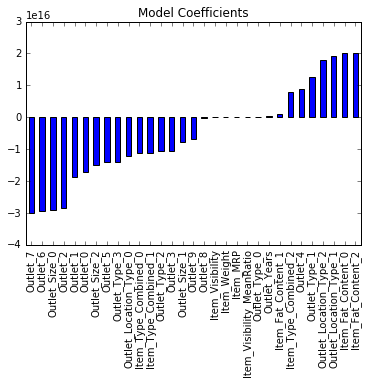

In [33]:
coef1 = pd.Series(model_lr.coef_, features).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')
plt.show()

## Decision Tree Model

### Prepare the decision tree model

In [34]:
#Decision Tree
pipe_dt = Pipeline([('clf', DecisionTreeRegressor(random_state=1))])

#max_depth=15, min_samples_leaf=100

max_depth_range = [6]
min_samples_leaf_range = [63]

param_grid = [{'clf__max_depth': max_depth_range, 'clf__min_samples_leaf': min_samples_leaf_range}]

gs_dt = GridSearchCV(estimator=pipe_dt, 
                  param_grid=param_grid, 
                  scoring='mean_squared_error', 
                  cv=10,
                  n_jobs=3)
dt = gs_dt.fit(X_train, y_train)
print("RMSE: ", np.sqrt(dt.best_score_ * -1))
print(dt.best_params_)

RMSE:  1085.16648034
{'clf__min_samples_leaf': 63, 'clf__max_depth': 6}


### Diagnosing bias and variance problems with learning curves

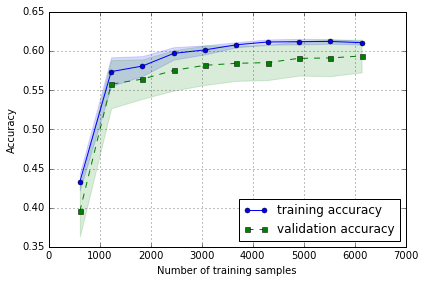

In [35]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=gs_dt.best_estimator_, 
                X=X_train, 
                y=y_train, 
                train_sizes=np.linspace(0.1, 1.0, 10), 
                cv=10,
                n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

### See the performance of the model on the independent test data

In [36]:
clf_dt = gs_dt.best_estimator_
clf_dt.fit(X_train, y_train)

print('Test Accuracy: %.3f' %clf_dt.score(X_test, y_test))

Test Accuracy: 0.594


### Make prediction on the test data using the model¶

In [37]:
clf_dt.fit(X, y)
#prediction on test data
test[target] = clf_dt.predict(test[features])

#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_dt_01.csv", index=False)

#coef2 = pd.Series(gs_dt.best_estimator_.feature_importances_, features).sort_values()
#coef2.plot(kind='bar', title='Feature Importances')

/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Random Forest

### Prepare the Random Forest model

In [38]:
#Decision Tree
pipe_rf = Pipeline([('clf', RandomForestRegressor(random_state=1))])

#max_depth=15, min_samples_leaf=100
n_estimators_range=[100]
max_depth_range = [6]
min_samples_leaf_range = [55]

param_grid = [{'clf__n_estimators': n_estimators_range, 
               'clf__max_depth': max_depth_range, 
               'clf__min_samples_leaf': min_samples_leaf_range}]

gs_rf = GridSearchCV(estimator=pipe_rf, 
                  param_grid=param_grid, 
                  scoring='mean_squared_error', 
                  cv=10,
                  n_jobs=3)

gs_rf = gs_dt.fit(X_train, y_train)

print("RMSE: ", np.sqrt(gs_dt.best_score_ * -1))
print(gs_dt.best_params_)

RMSE:  1085.16648034
{'clf__min_samples_leaf': 63, 'clf__max_depth': 6}


### Diagnosing bias and variance problems with learning curves

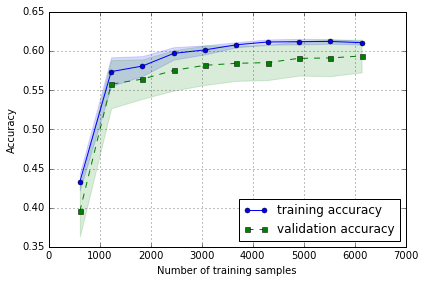

In [39]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=gs_dt.best_estimator_, 
                X=X_train, 
                y=y_train, 
                train_sizes=np.linspace(0.1, 1.0, 10), 
                cv=10,
                n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

### Estimate the performance of the best selected model

In [40]:
clf_rf = gs_rf.best_estimator_
clf_rf.fit(X_train, y_train)

print('Test Accuracy: %.3f' %clf_rf.score(X_test, y_test))

Test Accuracy: 0.594


In [41]:
clf_rf.fit(X, y)
#prediction on test data
test[target] = clf_rf.predict(test[features])


#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_rf_01.csv", index=False)

#coef2 = pd.Series(gs.feature_importances_, features).sort_values(ascending=False)
#coef2.plot(kind='bar', title='Feature Importances')

/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Adaboost

### Prepare the Adaboost model

In [42]:
#pipe_dt = Pipeline([('sc', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=1))])

tree = DecisionTreeRegressor(criterion='mse', max_depth=4)

ada = AdaBoostRegressor(base_estimator=tree, 
                        n_estimators=100,
                        learning_rate=0.075,
                        random_state=0)
ada = ada.fit(X_train, y_train)

predictions_train = ada.predict(X_train)
predictions_test = ada.predict(X_test)

print('Train Accuracy: %.3f' % np.sqrt(mean_squared_error(y_train, predictions_train)))
print('Test Accuracy: %.3f' % np.sqrt(mean_squared_error(y_test, predictions_test)))

Train Accuracy: 1075.130
Test Accuracy: 1093.432


In [43]:
ada = ada.fit(X, y)

#prediction on test data
test[target] = ada.predict(test[features])


#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_ada_01.csv", index=False)

/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## XGBoost

In [85]:
#XGBoost Regressor
xgb_regr = xgb.XGBRegressor()

n_estimators_range=[255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265]
max_depth_range = [1, 2, 3]
learning_rate_range = [0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034]

param_grid = [{'n_estimators': n_estimators_range, 
               'max_depth': max_depth_range, 
               'learning_rate': learning_rate_range}]

gs_xgb = GridSearchCV(estimator=xgb_regr, 
                  param_grid=param_grid, 
                  scoring='mean_squared_error', 
                  cv=10,
                  n_jobs=3)

#gs_xgb = gs_xgb.fit(X_train, y_train)
gs_xgb = gs_xgb.fit(X, y)

print("RMSE: ", np.sqrt(gs_xgb.best_score_ * -1))
print(gs_xgb.best_params_)

RMSE:  1080.03912284
{'n_estimators': 264, 'max_depth': 2, 'learning_rate': 0.03}


### Submission

In [86]:
clf = gs_xgb.best_estimator_
clf = best_xgb.fit(X, y)

#prediction on test data
test[target] = clf.predict(test[features])


#Export submission file:
IDcol.append(target)
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("model_xgb_01.csv", index=False)

/home/ranjank/installations/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
